In [1]:
#modeling sky subtraction model vs data points for 5/19/17 night
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const

from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

    
def target_1d(subimg,specaps,ds):    
    flux, unc = subimg.extract_spectrum(specaps)
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])
    return (flux, unc)

#below kinda replaces 'target_1d' above
#defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

# Subtracting Instrument Noise

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
#stating specific files/names to search for later on

flatid = 'DomeFlat'
atlasfiles = fits.open('henear.fits') #use for creating dispersion solution later 
targetID = '79005021831220-Catch22'
all_side_files_target = 'DoubleSpec/20170518/red*.fits'

#determing what instumentation noise is
flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170518/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
nfl = reduce_dblspec.create_normalized_flat(flats)   
header = atlasfiles[0].header    
    
#locating all files w/ the target & instrumentation noise subtraction
specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
#specs is the inst. noise subtracted group of files with data from target    
    
print("This is lenspecs:",len(specs))

print('specs is the inst. noise subtracted group of files with data from target ')

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


This is lenspecs: 5
specs is the inst. noise subtracted group of files with data from target 


# Creating Dispersion Solution

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


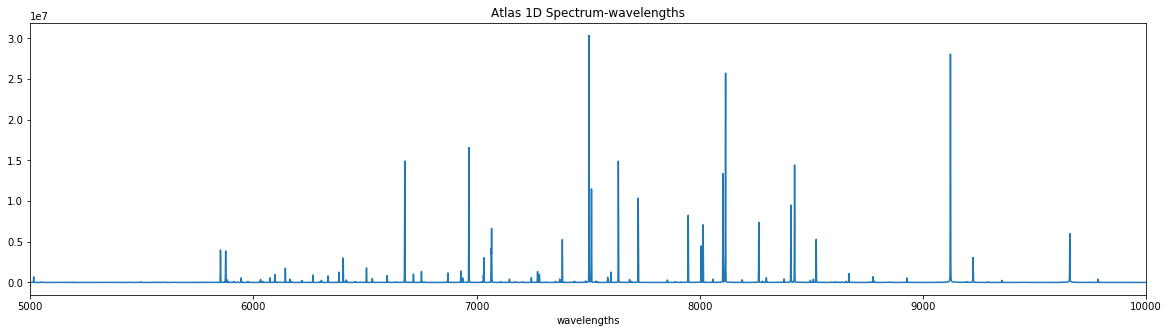

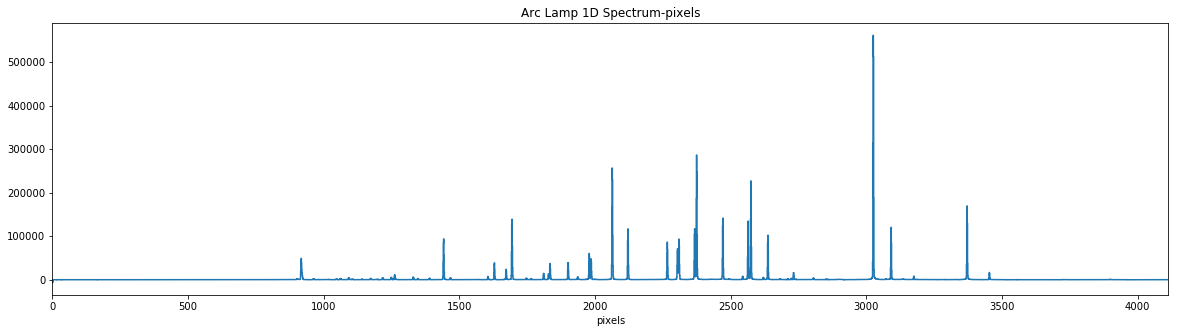

In [4]:
#creating a ds _ part one

#nameing all the datafiles needed
all_side_files_red10 = '20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = '20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = pipeline.dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10,flatid)

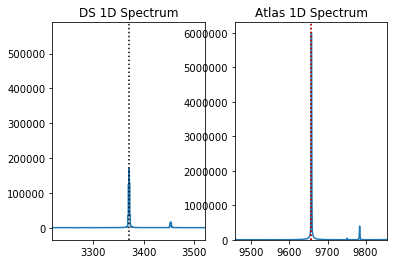

In [5]:
#creating a ds _ part two


#collecting guesses of matching lines from above graphs
#entering (px,wl)guesses & data
pipeline.guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 7.395561544387761, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Tried to find peak at 2338.0234170166977 but it's in a valley, not a peak"
Found line ArI at wl=8103.6931
Clipped 0 lines
Found line ArI at wl=8115.311
Clipped 0 lines
Failed to find line KrI at wl=8190.0543: "Guessed line's peak to base ratio is 0.9423511275390428, which is less than 10"
Found line ArI at wl=8264.5225
Clipped 0 lines
Failed to find line KrI at wl=8281.0495: "Guessed line's peak to base ratio is 0.9588258798377841, which is less than 10"
Failed to find line NeI at wl=8377.6065: "Guessed line's peak to base ratio is 9.895947290981596, which is less than 10"
Found line ArI at wl=8408.2096
Clipped 0 lines
Found line ArI at wl=8424.6475
Clipped 0 lines
Failed to find line NeI at wl=8495.3598: "Guessed line's peak to base ratio is 8.92091474828603, which is less than 10"
Failed to find line KrI at wl=8508.87: "Tri

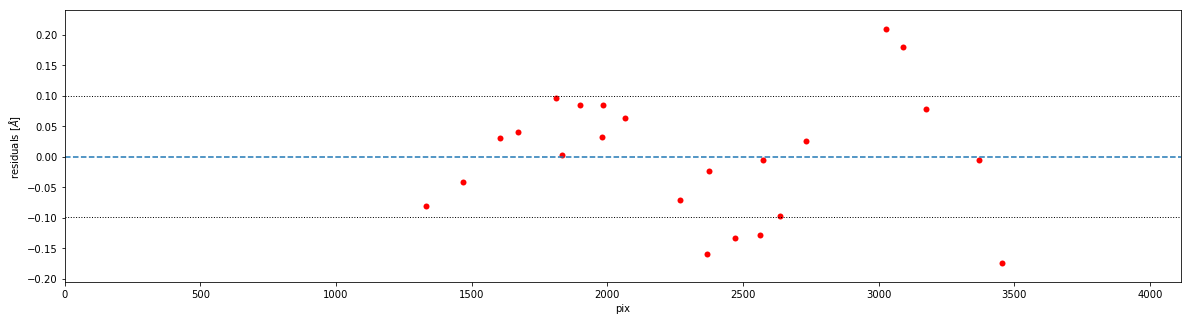

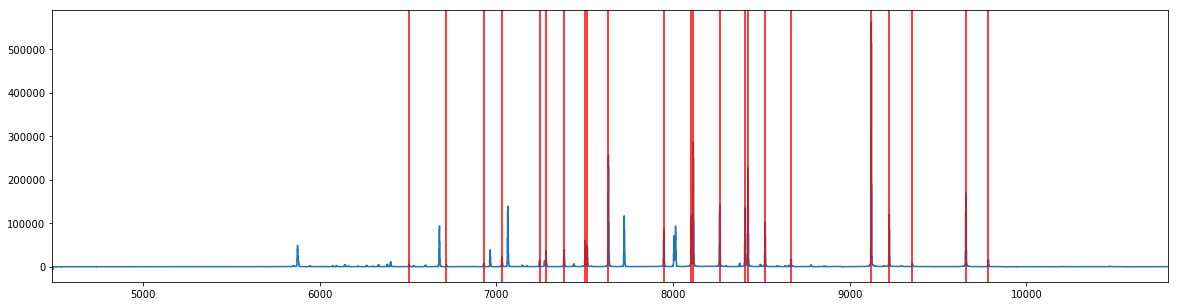

In [6]:
#creating a ds _ part three
ds_red10 = pipeline.goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10,flatid);

#this is the final ds to apply to catch22 data for this entire nb

# Sky Subtraction & stacking - data still 2D

In [7]:
#stacking all those instrument-noise-subtracted target data files-help increase s/n 

comb = reduce_dblspec.combine_imgs(specs) #comb-all files data from target stacked
skyaps=[(20,33),(265,320)]#[(55,120),(190,350)] #target 35-260
#skyaps=[(30,110),(180,400)] 
model=('poly',2)

subimg2, comb2, fitmodels = sky_subtract(comb,skyaps,model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

# Extracting 2D target spectrum (reducing spatial parameters)



FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!
flux data shape: (226, 4104)
NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


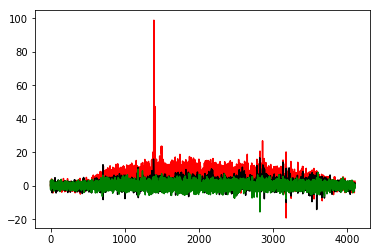

In [8]:
#first need to get 1D spectrum for each spatial pixel row in the 2D target data

#extracting target spec from whole 2d spec
target_aperature=(35,260) #target location

flux_data=[] #empty list to hold target 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #makes list for which rows to extracct spec from
#print (apslc) #as expected, +1 so doesnt cut off last value

#np.shape(subimg2.data)#(440, 4114)
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects a list of every row's spec within the target location
flux_data=np.array(flux_data)   
print("FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!" )
#need to find a way to sum over diff ranges of apslc 

#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #this wont affect spatial axes pix values, only amount of flux but thats negligible


plt.plot(flux_data[145],color='r')#near galaxy center
plt.plot(flux_data[45],color='k') #near galaxy edge
plt.plot(flux_data[224],color='g')#near opposite galaxy edge

print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

# Continnum Subtraction for Entire Target

shape new: (226, 4104)
new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array


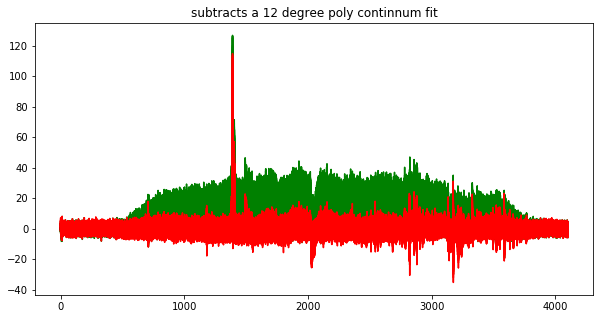

In [9]:
#good
#fitting continum for entire target now

#want to fit continum using a low-order poly (linear even??) for each spatial pix(row)
spatial_indexes = np.arange(0,len(flux_data))
new = []


for row in flux_data: #i isnt indiv data its each spatial row of data
    xpix = np.arange(0,len(row),1) #lists pixels by index
    polydeg = 12 #what degree of line to fit to continnum
    poly = np.poly1d(np.polyfit(xpix,row, polydeg)) #this determines the fit of the continum
    spec_subtracted = row - poly(xpix)
    new.append(spec_subtracted)
new = np.array(new)

divide = 4104 #number of spectral pixels in target data 
amtofrows = int(len(new)/divide) #also ensured int not float
plt.figure(figsize=(10,5))

print('shape new:',np.shape(new))

plt.plot(flux_data.T, color='g'); #original data
plt.plot(new.T,color='r'); #continum subtracted data
plt.title('subtracts a {:} degree poly continnum fit'.format(polydeg))

print('new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array')




### Determining H-alpha wl range

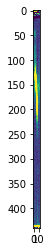

In [10]:
#determining better halpha range

#plt.figure(figsize=(2,15))

#using FULL ccd pix range
testingthis=subimg2.data[:,1396:1409]
vmin=-10
vmax=45
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels
#plt.ylim(50,250)
#plt.xlim(1380, 1400)

#conclusions
ha_range_fullccd = (1396, 1409)
ha_range_missing10 = (1386,1399)
harange_if10missing = flux_data[:,1386:1399] #flux_data off by 10 so subtract 10 from usual h-alpha's wl-in-pixspace range 



# Getting Galaxy Core Pix Value
### First Making 1D Spectrum
### CORE via FULL CCD SPECTRUM

shape (226, 1)
x: 0.0 y: 117.150852463 y is the spatial core location still in pixels & in the Reduced spectral range
to get full plate scale pix value add 35 and 10 from 1D spec cut due to oscillations
GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL: 152.150852463
SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!
double check corrections after decide about 10 pix cut around ln[8]


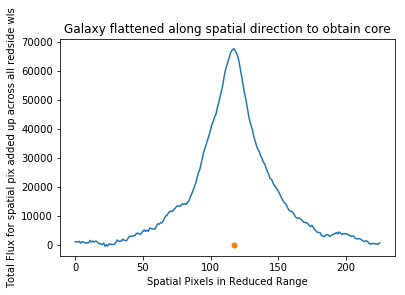

In [11]:
#USING FULL CCD SPECTRUM
#hack way of doing without a nice function from 1st cell

#flattening to be along spatial direction (histogram like)
flux_array = np.sum(flux_data,axis=1) #explicitly making an array
flux_array2d = flux_array[:, np.newaxis] #need 2d for centroiding


print('shape',np.shape(flux_array2d))
x_galcore, y_galcore = centroid_com(flux_array2d) #actually doing the centroiding

#plotting
plt.plot(flux_array2d);
plt.plot(y_galcore, x_galcore ,'.',markersize=10)
plt.xlabel('Spatial Pixels in Reduced Range')
plt.ylabel('Total Flux for spatial pix added up across all redside wls')
plt.title('Galaxy flattened along spatial direction to obtain core')

#below is amt of pix to add to target pix value to get matching plate pix #doesnt help total len tho
space_pix_correction = target_aperature[0] #from ln[9] in 1d target extract; maybe need to do this->#10 from pix cut from oscill in 1D
spatial_core_pix = y_galcore + space_pix_correction #(adds 35 to correct from target extraction),(10 from oscillations doesnt affect this b/c of spectral collapse in sum)

#conclusions
print('x:',x_galcore,'y:',y_galcore, 'y is the spatial core location still in pixels & in the Reduced spectral range')
print('to get full plate scale pix value add {:} and 10 from 1D spec cut due to oscillations'.format(target_aperature[0]))
print('GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL:',spatial_core_pix)
print('SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!')
print('double check corrections after decide about 10 pix cut around ln[8]')

### CORE via TWO SECTIONS

shape of first section: (226, 50) matches shape of second section: (226, 50)
shape of first section 2d: (226, 1)
shape of second section 2d: (226, 1)
first section centroid x,y: 0.0 119.585965541
second section centroid x,y: 0.0 119.823579711
This is the average pixel value of the core BEFORE spatial cutout corrections 119.704772626
Pixel Value of core along spatial axis wrt full CCD size 154.704772626


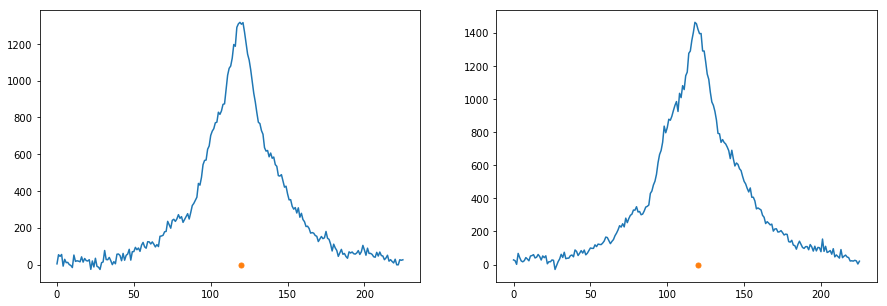

In [12]:
#USING SECTIONS SURROUNDING HALPHA WL RANGE
np.shape(flux_data)#(226,4104) #note that this is missing those 10 wl's
#also note flux_data is continuum subtracted

#below for reference
#harange_if10missing = flux_data[:,1386:1399] #flux_data off by 10 so subtract 10 from usual h-alpha's wl-in-pixspace range 
#plt.plot(harange_if10missing[11]); #saw clear ha peak so good

#making arrays surrounding h-alpha
upperha = 1399
lowerha = 1386
width_sections = 50
upper_one = lowerha - 1 #just to give it some distance
lower_one = upper_one - width_sections
lower_two = upperha + 1 #needed more distance (near&below core H-alpha leaks into this range so IF change ha range then make this 5 a 1 )
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))
#plt.plot(second_section[120]); #tried many diff row values for both sections here - satisified correct


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
x_first, y_first = centroid_com(first_section2d)
x_second, y_second = centroid_com(second_section2d)
print('first section centroid x,y:',x_first,y_first)
print('second section centroid x,y:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(y_first,x_first, '.', markersize=10)
ax2.plot(y_second,x_second, '.', markersize=10)

#averaging the two core values, the y's
core_array = np.array([y_first,y_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE spatial cutout corrections',core_avgcentroids)

#corrections to pixel value of avg section core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)




In [13]:
ha_range_missing10[0]

1386

# H-alpha Centroids/Gaussians/Unc for each space row in Entire Target

10
(226, 4104)


(1393, 1407)

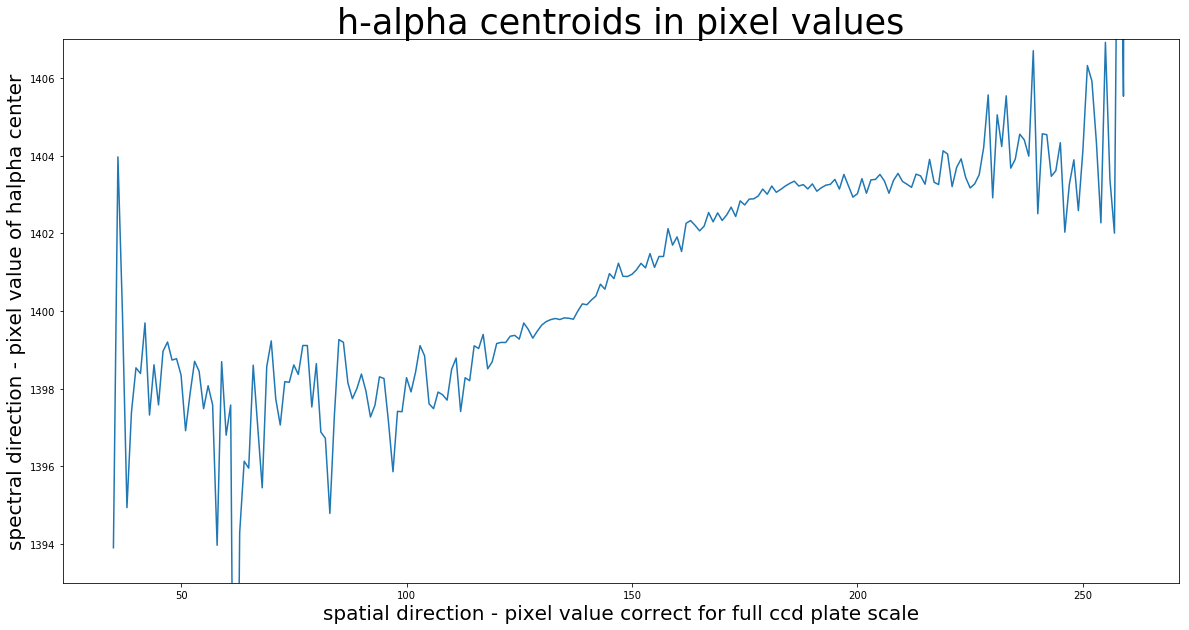

In [14]:
#below for reference, uses full ccd wl range - first defined when applied DS
wl = np.array(ds_red10.pixtowl(np.arange(len(subimg2.data[::][0]))))
wl_shorter2 = wl[1396:1409] #isolate wl around h-alpha using full ccd plate wl range formerly 1387:1400


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]


##below for reference- new is continuum subst target flux data (flux_data has 10 wl cut)
#b/c that 10 cut cutout those wl's and corresponding fluxes
print(wl_pix_correction)
print(np.shape(new))
new_short = new[:,1386:1399] #to go back to full ccd pix scale add ha_range_missing10[0] to pixel value


#gets halpha centroids/gaussians/uncertainities in target gal's range

for row in new_short: 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_xs, centroid_ys = centroid_com(flux_fake2d2)#finds center(x,y) of halpha for each row array
    mylist_ys2.append(centroid_ys)
    #print(centroid_xs, centroid_ys)
    centroids_pix.append(centroid_xs) #collects all halpha centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    mean = centroid_xs
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'][1][1])
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix=np.array(centroids_pix) #halpha centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
stddev = np.array(stddev) #std of gaussians in pixels
means = np.array(means) #gaussian peaks in pixels

#converting pixel values to be wrt full cdd

centroid_specpix_fullccd = centroids_pix + wl_pix_correction + ha_range_missing10[0]
gaussmax_specpix_fullccd = means + stddev + wl_pix_correction + ha_range_missing10[0]
gauss_mean = means + wl_pix_correction + ha_range_missing10[0]
#dont have to account for osciallations b/c used full ccd plate range b4 wl cut 4 h-alpha isolation
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
#plotting
plt.figure(figsize=(20,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of halpha center',fontsize=20)
plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha centroids in pixel values',fontsize=35)
plt.ylim(1393,1407)

# Sanity Check of Errors

Parameter('mean', value=1.2743014580861238)

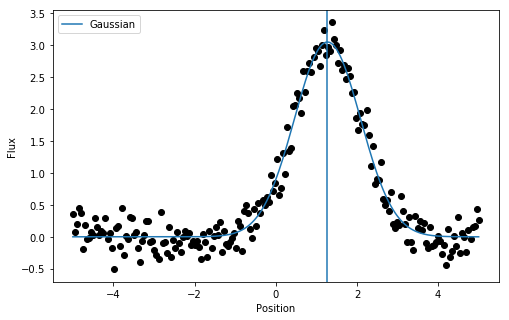

In [15]:
#testing with test data, how fitter works and what outputs are

# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)


# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)
 
# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
#plt.plot(x, t(x), label='Trapezoid')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')
plt.axvline(g.mean)
plt.legend(loc=2)

g.mean 

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev   
    ------------- ------------- -------------
    17.6447564771 7.88277495897 1.10978063594
fwhm 2.6133336871 std*2 2.21956127188
Dont think that the mean is gonna be good enough  - probably the reason for the errors when plotting - gaussian doesnt display same ha tilt


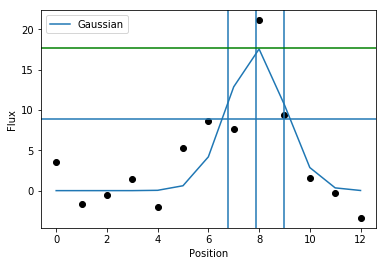

In [16]:
#tests to put into FOR LOOP way above
#using this one in for loop but theres still a few randow rows fit doesnt work for

test_row = 195 #162
#69/71, 159/161, 174/176, 183,186 209/211,    still good
#70,160, 175, 184, 185, 205, 210, 219,220,221, 225 bad 

x_gtest = ar(range(len(new_short[test_row]))) #independent data, space axis
y_gtest = new_short[test_row] #dependent data, flux values at space points



#works if change the amp,mean & std of ginit....but thatll change per row....so how??
g_init = models.Gaussian1D(amplitude=max(y_gtest), mean=6, stddev=2.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x_gtest, y_gtest)
print(g)
# Plot the data with the best-fit model
#plt.figure(figsize=(8,5))
plt.plot(x_gtest,y_gtest, 'ko')
plt.plot(x_gtest, g(x_gtest), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')

print('fwhm', g.fwhm, 'std*2', g.stddev*2)
#testing if mean gives the gaussian center x value...pretty close but very very slightly off
plt.axvline(g.mean)
plt.axvline(g.mean + g.stddev)
plt.axvline(g.mean - g.stddev)
plt.axhline(g.amplitude, color='g')


plt.axhline(g.amplitude/2)
plt.legend(loc=2)
#plt.ylim(59,66)
print('Dont think that the mean is gonna be good enough  - probably the reason for the errors when plotting - gaussian doesnt display same ha tilt')

# Generating Fake target gaussian data -- Come back and try to fix below

In [17]:
#generating fake target data that's all gaussian- so can expect specific results



spacetest=np.arange(0,226,1) #mimics number of isolated target rows
for i in spacetest:
    row = []
    # Generate fake data
    np.random.seed(0)
    x = np.linspace(-5., 5., 200)
    
    y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
    y += np.random.normal(0., 0.2, x.shape)
    #row = i,x,y?? try something similar to genereate a 2d array
    i = [[(x,y)]]
spacetest


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [18]:
np.shape(new_short)
print(new_short)

[[ 0.05754195 -0.82907997  2.5175674  ...,  2.47618219 -1.33181562
  -0.71084827]
 [ 0.70527602  0.07985957 -2.75951924 ...,  2.0192141  -1.48056574
   3.92572913]
 [ 0.29282794  0.88553709  4.36806786 ...,  1.66258051  0.6434394
  -0.24362075]
 ..., 
 [-1.7638746  -0.74981295 -2.62054382 ...,  2.40414177 -0.28948825
  -0.72733403]
 [-0.84659024 -1.63029556 -1.66717512 ...,  2.38044376 -3.21765757
   0.07634689]
 [-4.48183083 -1.69622977 -0.67698014 ...,  3.39143408 -0.11425134
   0.23825767]]


# Applying DS --pix to wl associations for velocity axis (spectral) 

# check b/c think i did this elsewhere in a better way

In [19]:
# this applys ds to pix values to get true wl's

#for ref 
#gaussmax_specpix_fullccd = means + stddev + wl_pix_correction + 1386
#gauss_mean = means + wl_pix_correction + ha_range_missing10[0]
#centroid_specpix_fullccd = centroids_pix + wl_pix_correction + ha_range_missing10[0]



centroids_wl = ds_red10.pixtowl(centroid_specpix_fullccd)*u.angstrom
gauss_meanWstd_wl  = ds_red10.pixtowl(gaussmax_specpix_fullccd)*u.angstrom
gauss_means_wl = ds_red10.pixtowl(gauss_mean)*u.angstrom
core_wl_sections = ds_red10.pixtowl(core_from_sections)*u.angstrom
core_wl = ds_red10.pixtowl(spatial_core_pix)*u.angstrom

# Converting Pixels --> kpc 

In [20]:
#centering around core first

#below for reference
#wl_pix_correction2 is pix of ha centroid in full plate scale
#target_spacepix_fullccd is row pix of each centroid
#spatial_core_pix is pixel value of the galaxy core in full plate scale

#still in pixel space
distance_pix_wrtcore = target_spacepix_fullccd - spatial_core_pix #for core wl using full ccd
distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around Halpha


In [21]:
#actual converting for loop CENTROIDS 
#good for core defined by 2 sections around halpha

#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    dbsp_pix_equiv = u.pixel_scale(redplatescale)
    r_in_pixel = i*u.pixel
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)
    #print(r_in_arcmin)
    distance = 37*u.Mpc # distance of object (host) from us
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    #print(r_in_kpc)
    more_sections = r_in_kpc #/ (1*u.kpc)
    #print(more_sections)
    distances_sections.append(more_sections.value)
distances_sections = np.array(distances_sections)
#print(distances_sections);

(1395, 1410)

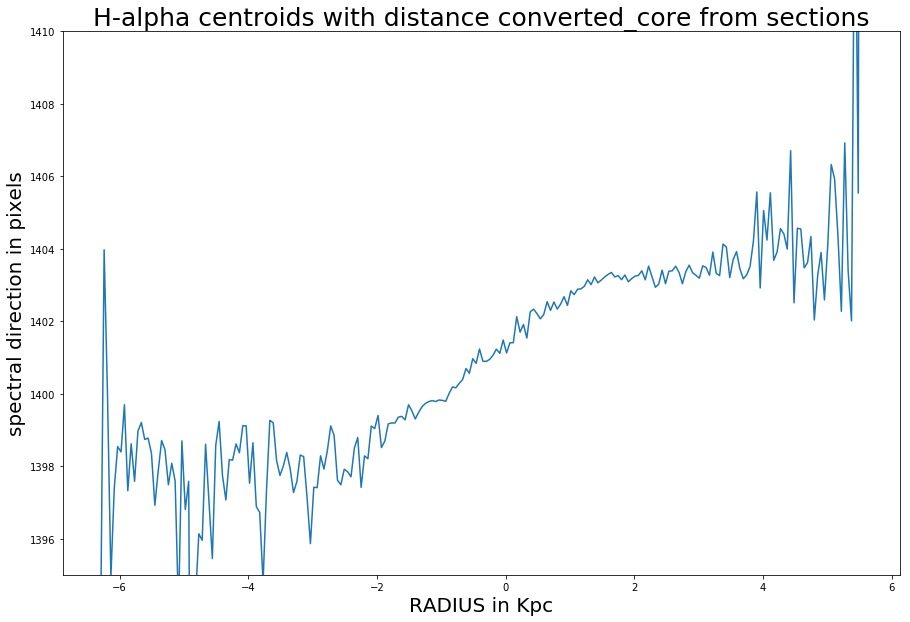

In [22]:
#good for core defined using 2 sections around halpha

#plt.figure(figsize=(5,3))

plt.figure(figsize=(15,10))
plt.plot(distances_sections * u.kpc,centroid_specpix_fullccd)
plt.title('H-alpha centroids with distance converted_core from sections',fontsize=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)


plt.ylim(1395,1410)

(226,)


(1399, 1410)

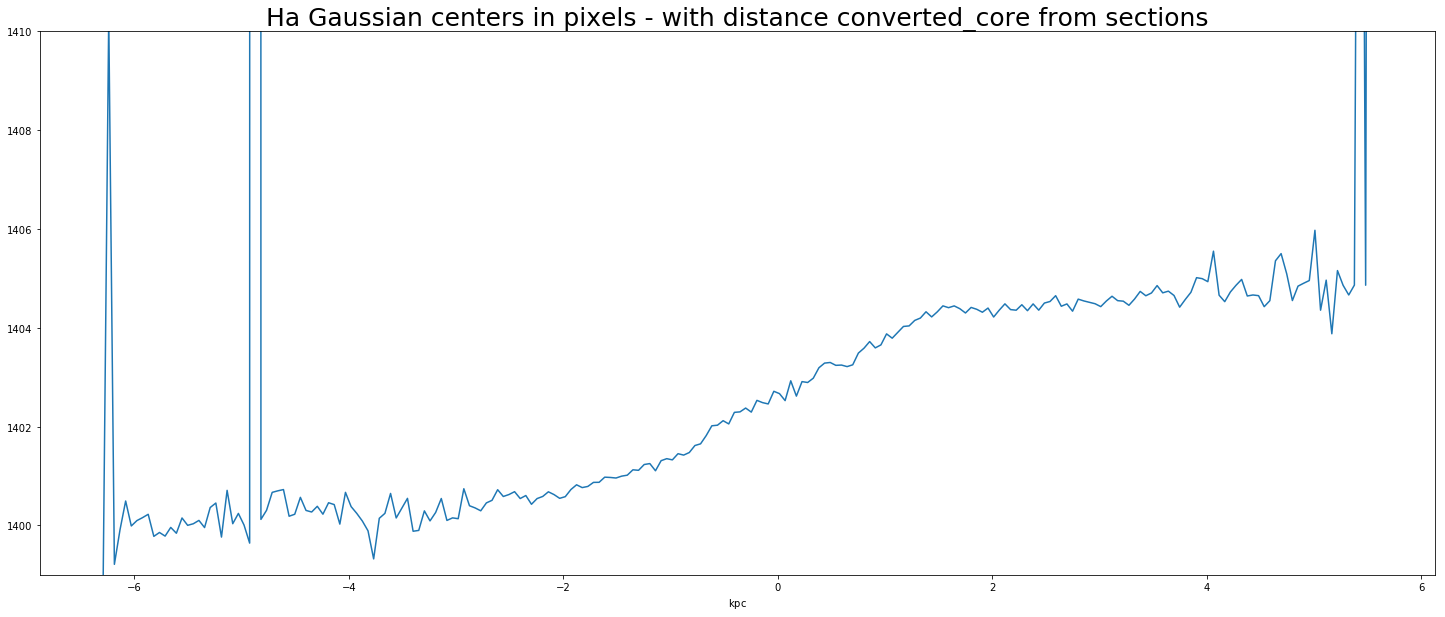

In [23]:
plt.figure(figsize=(25,10))
print(np.shape(gaussmax_specpix_fullccd))
plt.title('Ha Gaussian centers in pixels - with distance converted_core from sections', SIZE=25)
plt.plot(distances_sections * u.kpc,gaussmax_specpix_fullccd)
plt.ylim(1399,1410)

(226,)


(1399, 1410)

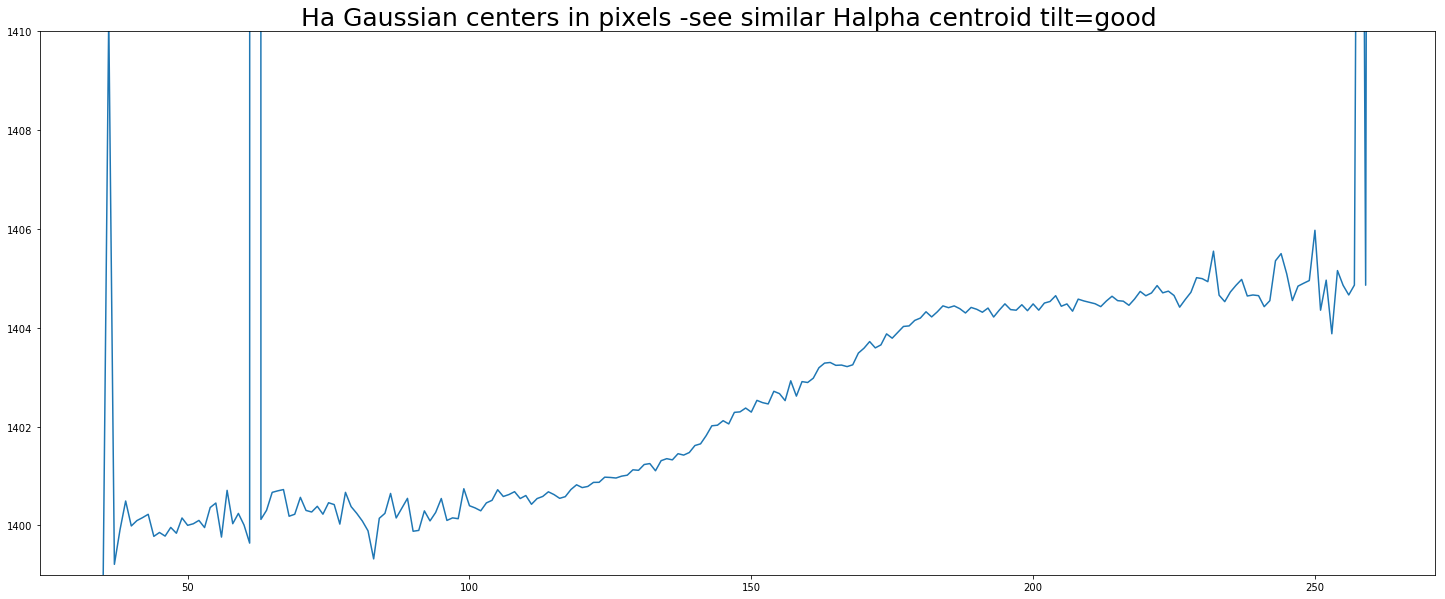

In [24]:
plt.figure(figsize=(25,10))
print(np.shape(gaussmax_specpix_fullccd))
plt.title('Ha Gaussian centers in pixels -see similar Halpha centroid tilt=good  ', SIZE=25)
plt.plot(target_spacepix_fullccd,gaussmax_specpix_fullccd)
plt.ylim(1399,1410)

# Converting Pixels ----> velocity

In [25]:
#using redshift formula to get velocity
#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#for reference
#centroids_wl = ds_red10.pixtowl(centroid_specpix_fullccd)*u.angstrom
#gauss_meanWstd_wl  = ds_red10.pixtowl(gaussmax_specpix_fullccd)*u.angstrom
#gauss_means_wl = ds_red10.pixtowl(gauss_mean)*u.angstrom
#core_wl_sections = ds_red10.pixtowl(core_from_sections)*u.angstrom
#core_wl = ds_red10.pixtowl(spatial_core_pix)*u.angstrom



#velocities not relative to the core
v_spec = (gauss_meanWstd_wl /(6563*u.angstrom)-1) * const.c
v_core = (core_wl_sections/(6563*u.angstrom)-1) * const.c
y_axis_velocity = v_spec - v_core

In [26]:
#hot mess - but if go back to keep ## lines


#using redshift formula to get velocity
#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core




#both below use core obtained from sections

#think this is a mistake- uses centroids 
#for ref#relative_tocore_pix_sections = wl_pix_corrected - core_wl_sections# rename as wl_pixshift_wrtcore
#wl_pix_corrected is the list of centroids
##velocity_sections = (relative_tocore_pix_sections / core_wl_sections) * c

#max gaussian velocity
#formula by parts - gauss pix wrt full ccd
#for ref#gauss_vel_pix = means + stddev + wl_pix_correction + 1386
##topofformula = (gauss_vel_wl - core_truewl_gauss)
##velocity_maxg = (topofformula / (6563*u.angstrom)-1) * c #replaced core_truewl_gauss with ha true wl to have correct formula
#old_velocity_maxg = (topofformula / core_truewl_gauss) * c #for comparisons

#mean gaussian velocity
#velocity from gausssian fits
#for ref# gauss_mean = means + wl_pix_correction + 1386
##topofformula2 = (gauss_mean_wl - core_truewl_gauss)
##velocity_gaussian = (topofformula2 / (6563*u.angstrom)-1) * c #replaced core_truewl_gauss with ha true wl to have correct formula
#old_velocity_gaussian = (topofformula2 / core_truewl_gauss) * c #for commparisons

##velocity_err = velocity_maxg - velocity_gaussian



# Calculating ErrorBars


In [27]:
arr = np.asarray



#taking sqrt of unc to get a true sigma
sigma_gauss_pix = []
for i in means_unc: #means_unc are unc's from the covariance matrix
    sigma = m.sqrt(abs(i))
    sigma_gauss_pix.append(sigma)
sigma_gauss_pix = arr([sigma_gauss_pix])
print('sig:',type(sigma_gauss_pix))

#making errors from pixels to velocity
#but cant do a pass thru ds...b/c pass thru value isnt a location pix its a diff
#run through dbspec platescale?? no thats arcsecs...wont get a vel

#first getting to correct ccd pix scale so can pass into ds
means_fullccd = means + wl_pix_correction + ha_range_missing10[0]
means_withsigma_fullccd = means + sigma_gauss_pix + wl_pix_correction + ha_range_missing10[0]

#making into velocities
#for reference #gauss_means_wl = ds_red10.pixtowl(gauss_mean)*u.angstrom
v_means_withsigma = ((ds_red10.pixtowl(means_withsigma_fullccd)*u.angstrom)/ (6563*u.angstrom)-1) * const.c 
v_means = ((ds_red10.pixtowl(means_fullccd)*u.angstrom)/ (6563*u.angstrom)-1) * const.c 
v_unc = v_means_withsigma - v_means


sig: <class 'numpy.ndarray'>


/Users/dee/miniconda3/lib/python3.6/site-packages/astropy/modeling/polynomial.py:841: RuntimeWarning: overflow encountered in multiply
  c0 = coeffs[-i] + c0 * x


(1, 226)


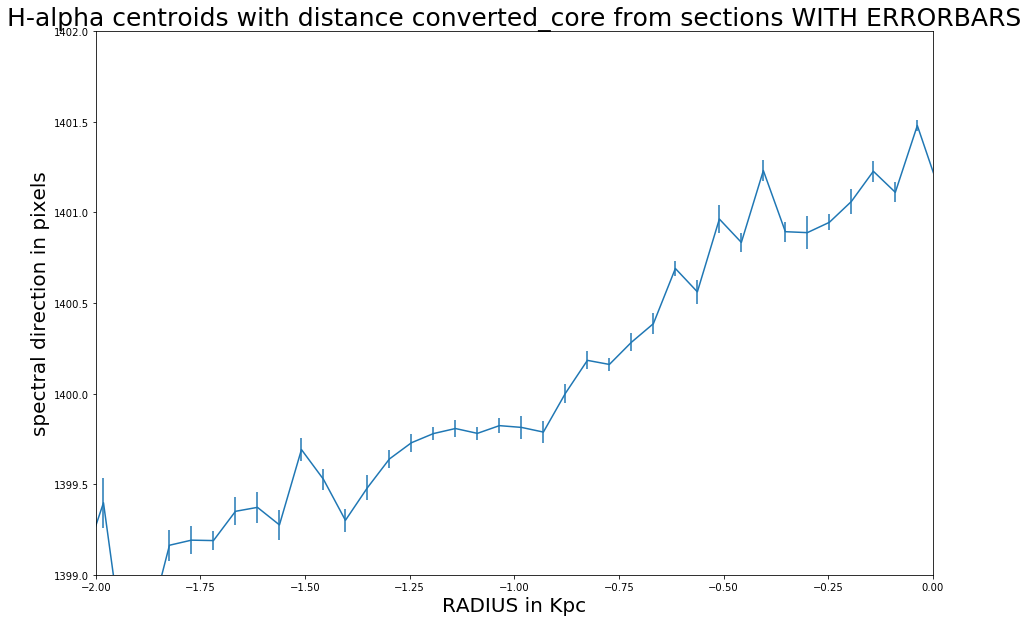

In [28]:
#dont know why i did this plot- but it does show can plot errors

x = arr([(distances_sections * u.kpc)])
y = arr([centroid_specpix_fullccd,])
print((np.shape(sigma_gauss_pix)))


#plt.figure(figsize=(5,3))

plt.figure(figsize=(15,10))
plt.errorbar(x, y, yerr=sigma_gauss_pix)


plt.title('H-alpha centroids with distance converted_core from sections WITH ERRORBARS',fontsize=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)


plt.ylim(1399,1402)
plt.xlim(-2,0)
plt.show()

ValueError: In safezip, len(args[0])=226 but len(args[1])=1

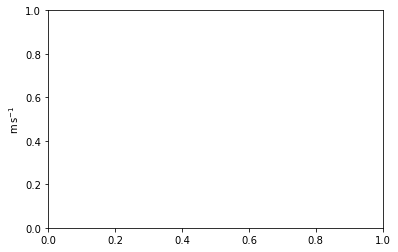

In [30]:
#v_unc = arr([v_unc])

plt.errorbar(x, y_axis_velocity, yerr=v_unc)

